## Question: What Type of Skillset is Optimal for Rock Climbing?

#### First lets initialize the data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import random
import math

#### Here are Our Classes

In [3]:
class Climber:
    """
    Class representing a climber
    """
    def __init__(self, reach, sloper, crimp, jug, position = np.array([5,0]), icon="*"):
        self.reach = reach
        ##Strength (Percent Chance of Sticking a Move To) on Different Types of Holds/Rock
        self.sloper = sloper
        self.crimp = crimp
        self.jug = jug
        ##Location on the wall
        self.position = position
        ##Icon for visualization
        self.icon = icon
        self.heights = []
        
    def make_move(self, holds):
        '''Accepts a list of holds on a wall, will attempt to move to a nearby hold higher up on the wall'''
        reachable = []
        for hold in holds:
            if self.reach > np.linalg.norm(self.position-hold.coords) and self.position[1]-hold.coords[1] < 0 and np.linalg.norm(self.position - hold.coords) != 0:
                reachable.append(hold)
        reached = []
        reached_dists = []
        for hold in reachable:
            if hold.type == 'jug':
                if random.random() <= self.jug:
                    reached.append(hold.coords)
            elif hold.type == 'sloper':
                if random.random() <= self.sloper:
                    reached.append(hold.coords)
            elif hold.type == 'crimp':
                if random.random() <= self.crimp:
                    reached.append(hold.coords)
        if not reached:
            return 'fall'
        
        for i in reached:
            x = math.dist(self.position, i)
            reached_dists.append(x)
        self.position = reached[np.argmin(reached_dists)]
        
        return 'stuck'
    
    def set_position(self, position = np.array([5, 0])):
        '''Sets position, can be used to reset after climbing a wall'''
        self.position = np.array(position)
        
        
    def average_h(self):
        return float(sum(self.heights))/len(self.heights)

In [4]:
class Hold:
    def __init__(self, coords, type_):
        self.coords = np.array(coords)
        self.type = type_

In [5]:
class Cell:
    """
    Class representing one 10 by 10 cell on a wall
    Attributes:
    slopers - number of sloper holds
    crimps - number of crimp holds
    jugs - number of jug holds
    height - height of the cell along the wall. should be multiple of 10
    holds - array of hold objects in the cell
    
    methods:
    show(): plots cell
    """
    def __init__(self, slopers, crimps, jugs, height = 0):
        ##Number of Each Type of Hold/Rock
        self.slopers = slopers
        self.crimps = crimps
        self.jugs = jugs
        self.num_cells = 1
        ##Setting Coordinates of the Holds
        self.total_holds = self.slopers + self.crimps + self.jugs
        self.x = np.random.randint(1, 11, size = self.total_holds)
        self.y = np.random.randint(1, 11, size = self.total_holds)
        self.holds = []
        self.hold_types = []
        for i in range(slopers):
            new_hold = Hold([self.x[i], self.y[i]+height], "sloper")
            self.holds.append(new_hold)
            self.hold_types.append("sloper")
        for j in range(crimps):
            new_hold = Hold([self.x[j+i], self.y[j+i]+height], "crimp")
            self.holds.append(new_hold)
            self.hold_types.append("crimp")
        for k in range(jugs):
            new_hold = Hold([self.x[k+j+i], self.y[k+j+i]+height], "jug")
            self.holds.append(new_hold)       
            self.hold_types.append("jug")
        
    def show(self):
        '''Plots cell with all holds'''
        sns.scatterplot(x = self.x,y = self.y, hue = self.hold_types, style = self.holds, palette = 'bright', s = 100)
        plt.axis([0,10, 0, 10])
        plt.show()
    


In [6]:
class Wall:
    """
    Class representing a whole wall, made up of cells
    """
    def __init__(self, smallwall, cell):
        ##Number of Each Type of Hold/Rock
        self.slopers = smallwall.slopers + cell.slopers
        self.crimps = smallwall.crimps + cell.crimps
        self.jugs = smallwall.jugs + cell.jugs
        self.num_cells = smallwall.num_cells + cell.num_cells
        self.hold_types = smallwall.hold_types + cell.hold_types
        ##Setting Coordinates of the Holds
        self.total_holds = self.slopers + self.crimps + self.jugs
        self.x = np.concatenate((smallwall.x, cell.x))
        self.y = np.concatenate((smallwall.y, cell.y + np.repeat(10*(self.num_cells-1), len(cell.y))))
        self.holds = np.concatenate((smallwall.holds, cell.holds))
        self.hold_cords = []
        for i in range(self.total_holds):
            self.hold_cords.append([self.x[i], self.y[i]])
        
    def show(self, show_scale = 1, title = 'Rock Wall'):
        '''Plots Wall with all holds shown'''
        fig = plt.figure(figsize = (10*show_scale, len(self.x)*show_scale))
        sns.scatterplot(x = self.x,y = self.y, hue = self.hold_types, style = self.hold_types, palette = 'bright', s = 100)
        plt.axis([0,10, 0, 10*self.num_cells])
        plt.title(title)
        plt.show()
        
    def run_wall(self, climber):
        '''Takes in a climber object and simulates the climber attempting to climb the wall. 
        Returns a list of all points the holder occupied during their path'''
        path = []
        status = "stuck"
        while status == "stuck":
            path.append(climber.position)
            status = climber.make_move(self.holds)
        climber.set_position()
        return path
    
    def plot_path(self, path, show_scale = 1, title = 'Rock Wall'):
        '''Plots wall along with climber path for the given path'''
        fig = plt.figure(figsize = (10*show_scale, len(self.x)*show_scale))
        sns.scatterplot(x = self.x,y = self.y, hue = self.hold_types, style = self.hold_types, palette = 'bright', s = 100)
        plt.axis([0,10, 0, 10*self.num_cells])
        plt.title(title)
        plt.plot(*zip(*path))
        plt.show()

Below are all of the functions we use

In [6]:
##Notes
##We decided two holds being placed in the same location is appropriate given that many climbing gyms will drill one hold on 
##top of another to make the move easier/more attainable for different climbing types

In [17]:
def create_wall(cells, slopers, crimps, jugs):
    '''Creates a wall with given specifications'''
    cell1 = Cell(slopers, crimps, jugs)
    cell2 = Cell(slopers, crimps, jugs, 10)
    smallwall = Wall(cell1,cell2)
    for i in range(cells-2):
        cell1 = Cell(slopers, crimps, jugs, (i+2)*10)
        smallwall = Wall(smallwall, cell1)
    return smallwall

In [8]:
def create_climbers(n, reach, sloper, crimp, jug):
    '''Each input other than n is a list of 2 numbers, a min and a max for that attribute
        Creates a list of n climbers with attributes '''
    climber_list = []
    for i in range(n):
        reach1 = random.uniform(reach[0], reach[1])
        sloper1 = random.uniform(sloper[0], sloper[1])
        crimp1 = random.uniform(crimp[0], crimp[1])
        jug1 = random.uniform(jug[0], jug[1])
        climber1 = Climber(reach1, sloper1, crimp1, jug1)
        climber_list.append(climber1)
    return climber_list

In [9]:
def simulate(climbers, walls):
    '''Takes in a list of climbers and walls, runs all climbers on all walls, keeping track of how high they made it'''
    for wall in walls:
        for climber in climbers:
            path = wall.run_wall(climber)
            height = path[-1][1]
            climber.heights.append(height)
            

#### Example showing our code in action (one wall, one climber, plot path)

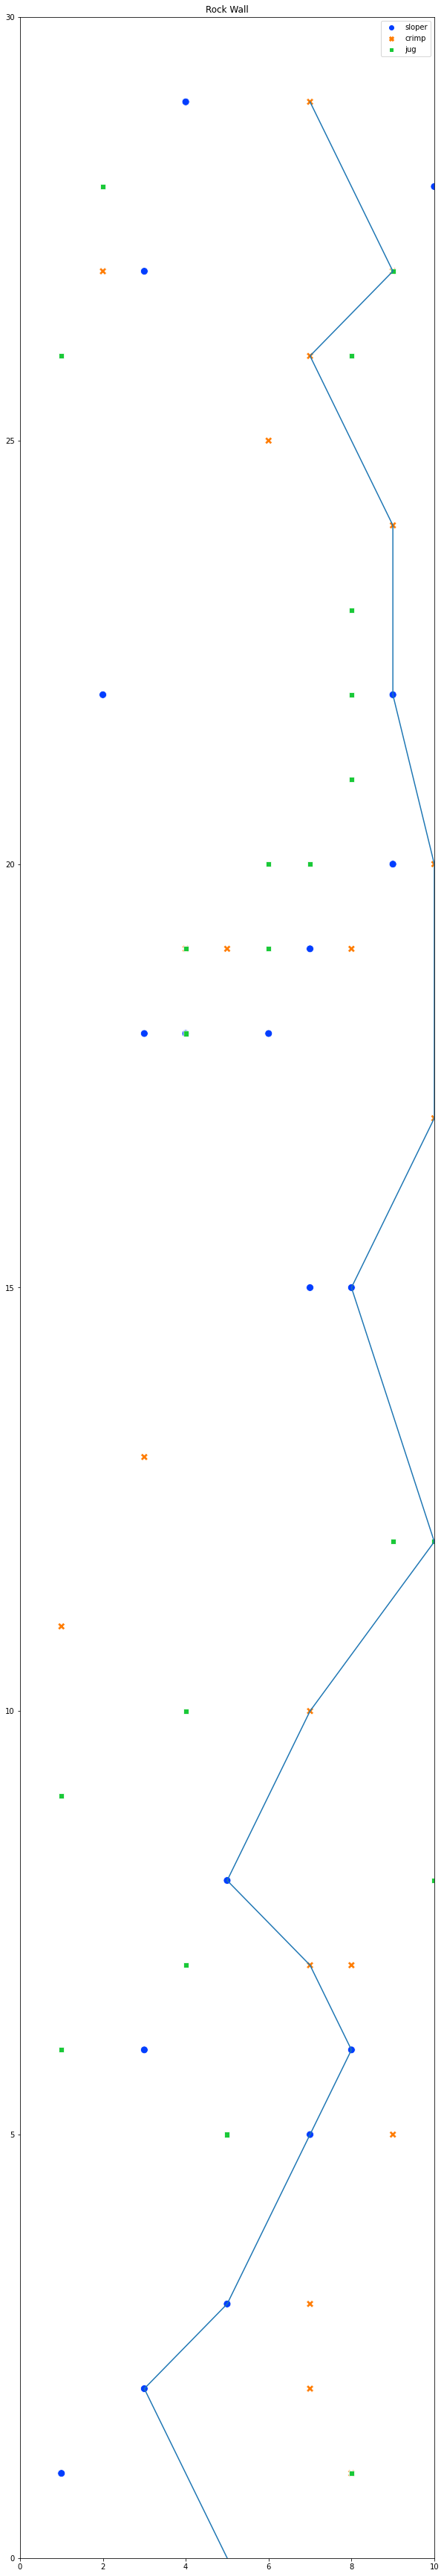

In [10]:
# Below we created an elaborate wall

cell1 = Cell(7,7,7)
cell2 = Cell(7,7,7,10)
cell3 = Cell(7,7,7,20)
wall1 = Wall(cell1, cell2)
wall1 = Wall(wall1, cell3)

# Below we created a climber with a reach of 5 and an 80% success rate in each hold

climber1 = Climber(5, 0.8, 0.8, 0.8)

# Below we showed the route the climber took

wall1.plot_path(wall1.run_wall(climber1))

#### In order to answer our question, we're going to create 100 climbers and 20 walls. Of the 100 climbers . . .

#### 20 will excel at reach

#### 20 will excel at slopers

#### 20 will excel at crimps

#### 20 will excel at jugs

#### 20 will be jacks of all trades

#### We will do a similar thing for the walls. We'll create some walls that have even amounts of each rock, and other walls that have more of other rocks.

We have to keep in mind that some holds are harder than others. In particular, Jugs are the easiest, Crimps are in the middle, and Slopers are the hardest. If we didn't take this into account, then all the different holds would essentially be the same. 

This also means we need to set a base value for each hold. ***We'll set Sloper to 0.6, Crimp to 0.7, and Jug to 0.8.*** From here, we can make climbers with reasonable data. 

In [42]:
# Let's make some climbers

sloper_climbers = create_climbers(25, [4,6], [.75, .85], [.65, .75], [.75, .85])
crimp_climbers = create_climbers(25, [4,6], [.55, .65], [.85, .95], [.75, .85])
jug_climbers = create_climbers(25, [4,6], [.55, .65], [.65, .75], [.9, 1])
# We'll give the All Around Climbers a bit of a boost in every stat
all_around_climbers = create_climbers(25, [4,6], [.6, .7], [.7, .8], [.8, .9])

In [43]:
# Let's make some walls

all_walls = []

for i in range(5):
    all_walls.append(create_wall(10,7,7,7))
    all_walls.append(create_wall(10,11,5,5))
    all_walls.append(create_wall(10,5,11,5))
    all_walls.append(create_wall(10,5,5,11))

#### Now we're ready to simulate and collect data

In [44]:
sloper_h = []

simulate(sloper_climbers, all_walls)
for climber in sloper_climbers:
    sloper_h.append(climber.average_h())

In [45]:
crimp_h = []

simulate(crimp_climbers, all_walls)
for climber in crimp_climbers:
    crimp_h.append(climber.average_h())

In [46]:
jug_h = []

simulate(jug_climbers, all_walls)
for climber in jug_climbers:
    jug_h.append(climber.average_h())

In [47]:
all_around_h = []

simulate(all_around_climbers, all_walls)
for climber in all_around_climbers:
    all_around_h.append(climber.average_h())

### Data Analysis Code

Text(0, 0.5, 'Average Height')

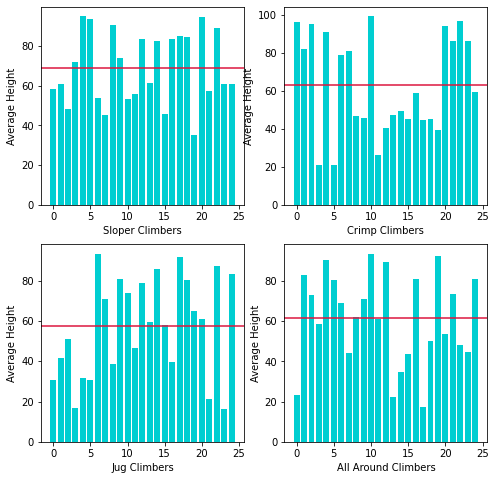

In [53]:
numclimbers = range(0,25)

plt.figure(figsize=(8, 8))

plt.subplot(2,2,1) # The first subplot of the 2x2
plt.bar(numclimbers,sloper_h, color='darkturquoise')
plt.axhline(np.mean(sloper_h), color='crimson')
plt.xlabel('Sloper Climbers')
plt.ylabel('Average Height')

plt.subplot(2,2,2) # The first subplot of the 2x2
plt.bar(numclimbers,crimp_h, color='darkturquoise')
plt.axhline(np.mean(crimp_h), color='crimson')
plt.xlabel('Crimp Climbers')
plt.ylabel('Average Height')

plt.subplot(2,2,3) # The first subplot of the 2x2
plt.bar(numclimbers,jug_h, color='darkturquoise')
plt.axhline(np.mean(jug_h), color='crimson')
plt.xlabel('Jug Climbers')
plt.ylabel('Average Height')

plt.subplot(2,2,4) # The first subplot of the 2x2
plt.bar(numclimbers,all_around_h, color='darkturquoise')
plt.axhline(np.mean(all_around_h), color='crimson')
plt.xlabel('All Around Climbers')
plt.ylabel('Average Height')